In [1]:
import torch
import torch.backends.cudnn as cudnn
from torchvision import transforms
import numpy as np
from PIL import Image
import os
import glob

In [2]:
from geo_data import create_anchor_transform
from libs.ConvNeXt.models.convnext import ConvNeXt
import matplotlib.pyplot as plt
imap = plt.imread("europe.png")
from tqdm import tqdm_notebook
from geo_data import build_geo_dataset

In [3]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
trans = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

COORD_REF = np.array((50, 10))

In [5]:
images = glob.glob('./data/*.png')
countries = []
for image in images:
    name = os.path.basename(image)[:-4]
    country, _ = name.split("_")
    if country not in countries:
        countries.append(country)
countries.sort()

cls_map = {i: c for i, c in enumerate(countries)}


In [8]:
device = torch.device("cuda:0")
model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], num_classes=46)

model.load_state_dict(torch.load("logs/ConvNeXt-B_cls/checkpoint-47.pth", map_location='cpu')['model'], strict=True)

model = model.to(device)
model.eval()

ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(512, 1024, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=128, out_features=512, bias=True)
        (act): GELU(approximate=none)
        (pwconv2): Linear(in_features=512, out_features=128, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), p

In [12]:
@torch.no_grad()
def pred_cls(img_path):
    cls, coord = img_path[:-4].split("_")
    
    img = Image.open(os.path.join(data_path, img_path))
    img_tensor = trans(img).to(device)
    img_tensor = img_tensor.unsqueeze(0)
    
    pred = model(img_tensor)
    pred = pred.squeeze().cpu()
    return pred.argmax().item()

In [32]:
anchor_samples = [ 
    "AD_42.528,1.56927.png", "AL_41.32654,19.82209.png", "AT_47.73333,14.21667.png", "BA_43.91194,18.08083.png", "BE_50.78263,4.5334.png", "BG_42.71231,25.3329.png", "BY_53.0245,26.3403.png", "CH_46.90981,8.11206.png", "CY_35.119479999999996,33.28853.png", "CZ_49.73456,15.29297.png", "DE_50.39996,9.98198.png", "DK_55.80849,10.581669999999999.png", "EE_58.63053,25.55402.png", "ES_39.68888,-3.50281.png", "FI_61.929730000000006,25.15144.png", "FR_46.91745,2.49814.png", "GB_52.81773,-1.76009.png", "GR_37.97451,23.51769.png", "HR_44.655,15.95083.png", "HU_47.25,19.06667.png", "IE_53.32528000000001,-7.979439999999999.png", "IS_64.13267,-20.30651.png", "IT_43.43218,11.77323.png", "LI_47.17556,9.57287.png", "LT_55.41019,23.7299.png", "LU_49.64506,6.12932.png", "LV_57.0619,24.84465.png", "MC_43.74041,7.42311.png", "MD_47.01095,28.85176.png", "ME_42.39333,18.89028.png", "MK_41.63468,21.40268.png", "MT_35.94556,14.38972.png", "NL_52.1738,5.48497.png", "NO_62.20631,10.63725.png", "PL_51.85225,19.59197.png", "PT_39.66978,-8.9958.png", "RO_45.68811,24.97548.png", "RS_44.24947,20.39613.png", "RU_54.1766,37.8881.png", "SE_59.06565,15.337470000000001.png", "SI_46.05804,14.82515.png", "SK_48.56315,19.3029.png", "SM_43.90867,12.44808.png", "UA_48.57325,29.71874.png", "VA_41.90394,12.45401.png", "XK_42.54018,20.28793.png",
]
coo_map = {}
for fname in anchor_samples:
    name = os.path.basename(fname)[:-4]
    country, coord = name.split("_")
    lat, lng = coord.split(",")
    country, _ = name.split("_")
    coo_map[country] = (float(lat), float(lng))

In [17]:
data_path = "./eval"

reals, preds = [], []

acc = 0
for fname in os.listdir("./eval"):
    name = os.path.basename(fname)[:-4]
    latlng = np.array([float(lat), float(lng)])
    pred = pred_cls(fname)
    
#     print(cls_map[pred], country)
    acc += cls_map[pred]==country
print(acc)

0


In [33]:
@torch.no_grad()
def pred_N_show(img_path):
    img = Image.open(img_path).convert("RGB")
#     print(img.size)
    img_tensor = trans(img).to(device)
    img_tensor = img_tensor.unsqueeze(0)
    
    pred = model(img_tensor)
    pred = pred.squeeze().cpu()
    pred = pred.argmax().item()
    pred_country = cls_map[pred]
    
    pred_coord = coo_map[pred_country]
    print(pred_country, pred_coord)
    plt.rcParams["figure.figsize"] = (11,4)
    fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [3, 2]})
    ax1.scatter([pred_coord[1]], [pred_coord[0]], c='r', label='real', s=5)
    print(img_path)
    ax1.imshow(imap, alpha=0.5, aspect='auto', extent=[-27.17555, 62.23576, 30.49074, 74.90111])
    ax2.imshow(plt.imread(img_path), aspect='auto')
    plt.show()
    

GB (52.81773, -1.76009)
./demo/62902e6cb95475456e78a8e4879c9a6.png


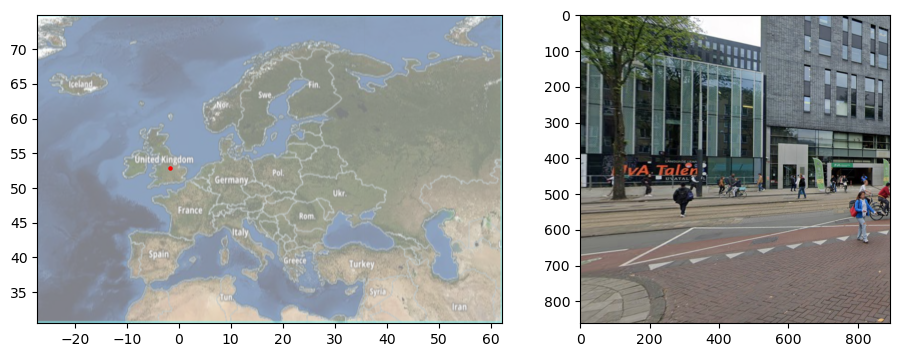

In [41]:
pred_N_show("./demo/62902e6cb95475456e78a8e4879c9a6.png")